# Building a YOLOv3 Object Detector with Darknet in the Cloud! (GPU ENABLED)
This tutorial will help you build YOLOv3 easily in the cloud with GPU enabled so that you can run real-time object detections as well as train your very own custom object detector!

# Step 1: Enabling GPU within your notebook
You need to enable GPU acceleration within your Colab notebook so that your YOLOv3 system will be able to process detections over 100 faster than CPU.

### Steps:

### i) Click **Edit** at top left of your notebook
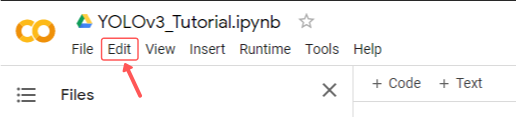
### ii) Click **Notebook Settings** within dropdown
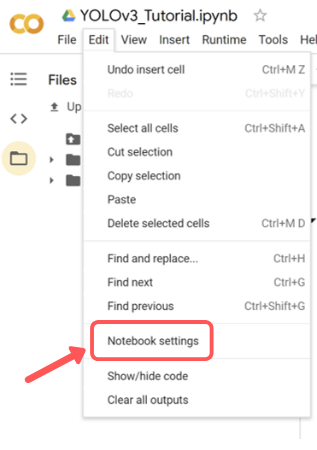
### iii) Under 'Hardware Accelerator' select **GPU** and then hit **Save**
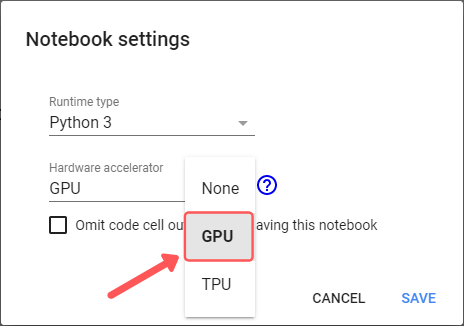

Your notebook should now have GPU enabled!

# Step 2: Cloning and Building Darknet
The following cells will clone darknet from AlexeyAB's famous repository, adjust the Makefile to enable OPENCV and GPU for darknet and then build darknet.

Do not worry about any warnings when you run the '!make' cell!

In [1]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15460, done.
remote: Total 15460 (delta 0), reused 0 (delta 0), pack-reused 15460
Receiving objects: 100% (15460/15460), 14.07 MiB | 19.58 MiB/s, done.
Resolving deltas: 100% (10387/10387), done.


In [2]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [3]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [4]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# Step 3: Download pretrained YOLOv3 weights
YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [5]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

# Training a Custom YOLOv3 Object Detector in the Cloud!
Now comes the fun part! It is time to create your very own custom object detector, all within the cloud for free! The options are endless for what objects/classes you can make your detector detect. So think of something creative or just follow along with what I create. It is up to you!

**WOW! YOU ARE KILLING IT SO FAR!** 

This requires a couple tricks and tips so make sure to follow along closely with the rest of the tutorial.

In order to create a custom YOLOv3 detector we will need the following:

*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt file (test.txt is optional here as well)


# Step 1: Gathering and Labeling a Custom Dataset
In order to create a custom object detector you need a good dataset of images and labels so that the detector can be efficiently trained to detect objects.

This can be done in two ways. through  or through using Google images or creating your own dataset and using an annotation tool to manually draw labels. **(I recommend the first way!)**

### Method 1: Using Google's Open Images Dataset (RECOMMENDED)
This method is the method I recommend as you can gather thousands of images and auto-generate their labels within minutes! Gathering a dataset from Google's Open Images Dataset and using OIDv4 toolkit to generate labels is easy and time efficient. The dataset contains labeled images for over 600 classes! [Explore the Dataset Here!](https://storage.googleapis.com/openimages/web/index.html)

Watch one of my previous youtube videos on how to do use this approach to create your own custom dataset!

[Creating a Custom YOLOv3 Dataset (Video)](https://www.youtube.com/watch?v=_4A9inxGqRM)

Here is a link to my github repository for the OIDv4 toolkit! [Github Repo](https://github.com/theAIGuysCode/OIDv4_ToolKit)

For this tutorial I will be creating a safari animal object detector using data from Google's Open Images Dataset. I ran the following commands within the toolkit.
```
python main.py downloader --classes Elephant Giraffe Hippopotamus Tiger Zebra --type_csv train --limit 300 --multiclasses 1
```
This creates a folder with 300 images for each of Elephant, Giraffe, Hippopotamus, Tiger, and Zebra images. So 1500 images in total and saves them all to one folder.

Within the root OIDv4_ToolKit folder open the file classes.txt and edit it to have the classes you just downloaded, one per line.
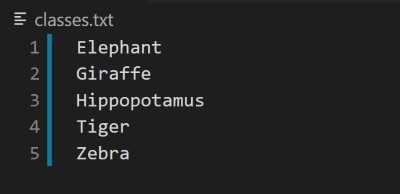

Now convert the image annotations:
```
python convert_annotations.py
```
This converts all labels to YOLOv3 format which can now be used by darknet to properly train our custom object detector.

Remove the old 'Label' folder in the OIDv4 toolkit which contains the non YOLOv3 formatted labels by running: (your file path will have a different name for Elephant_Giraffe.. depending on which classes you downloaded.
```
rm -r OID/Dataset/train/Elephant_Giraffe_Hippopotamus_Tiger_Zebra/Label/
```
If this command doesn't work on your machine then just go to the folder with 'Label' and right click and hit **Delete** to manually delete it.

The folder with all your images and annotations should now look like this. Each image should have a text file with the same name.
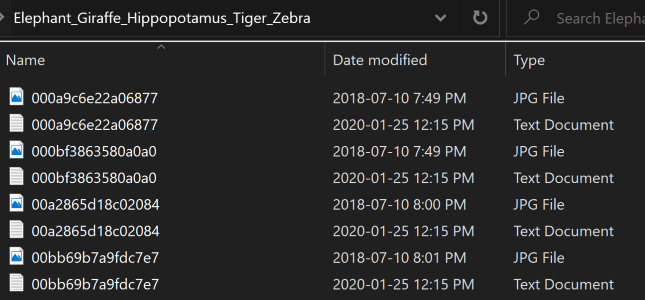

## You have sucessfully generated a custom YOLOv3 dataset! Congrats!

### Method 2: Manually Labeling Images with Annotation Tool
If you can't find the proper images or classes within Google's Open Images Dataset then you will have to use an annotation tool to manually draw your labels which can be a tiresome process.

I have created a previous video where I walk through how to mass download images from Google Images along with how to use LabelImg, an annotation tool, in order to create a custom dataset for YOLOv3. Hit link below to learn how.

[Create Labels and Annotations for Custom YOLOv3 Dataset (Video)](https://www.youtube.com/watch?v=EGQyDla8JNU)

After following the tutorial video you should now have a folder with images and text files like the one above.

## You have successfully generated a custom YOLOv3 dataset! Congrats!

# Step 2: Moving Your Custom Dataset Into Your Cloud VM
So now that you have your dataset properly formatted to be used for training we need to move it into this cloud VM so that when it comes the time we can actually use it for training.

I recommend renaming the folder with your images and text files on your local machine to be called '**obj**' and then creating a .zip folder of the 'obj' folder. Then I recommend uploading the zip to your Google Drive. So you should now have obj.zip someplace in your Google drive. 

This will **greatly reduce** the time it takes to transfer our dataset into our cloud VM.

Now we can copy in the zip and unzip it on your cloud VM.

# Step 3: Configuring Files for Training
This step involves properly configuring your custom .cfg file, obj.data, obj.names and train.txt file.

I have a detailed video on how to properly configure all four of these files to train a custom yolov3 detector. I will spare the time and ask you to watch the video in order to properly learn how to prepare the files.

You can access the video with this link! [Configuring YOLOv3 Files for Training](https://www.youtube.com/watch?v=zJDUhGL26iU&t=300s)

## i) Cfg File
Copy over the yolov3.cfg to edit by running the cell below.

Now you need to edit the .cfg to fit your needs based on your object detector. Open it up in a code or text editor to do so.

If you downloaded cfg to google drive you can use the built in  **Text Editor** by going to your google drive and double clicking on yolov3_custom.cfg and then clicking on the **Open with** drop down and selectin **Text Editor**.
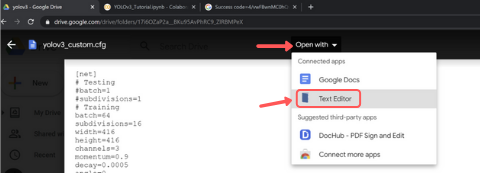

I recommend having **batch = 64** and **subdivisions = 16** for ultimate results. If you run into any issues then up subdivisions to 32.

Make the rest of the changes to the cfg based on how many classes you are training your detector on.

**Note:** I set my **max_batches = 10000**, **steps = 8000, 9000**, I changed the **classes = 5** in the three YOLO layers and **filters = 30** in the three convolutional layers before the YOLO layers. 

**Optional:** In each of the three yolo layers in the cfg, change one line from random = 1 to **random = 0** to speed up training but slightly reduce accuracy of model. Will also help save memory if you run into any memory issues.


## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** and you will make this file exactly the same as your classes.txt in the dataset generation step.

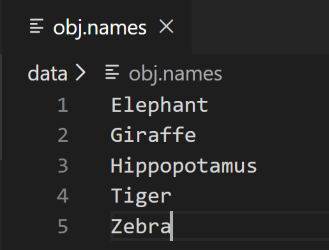

You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

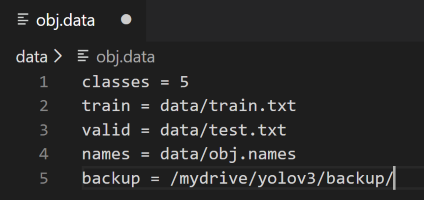



## iii) Generating train.txt
The last configuration file needed before we can begin to train our custom detector is the train.txt file which hold the relative paths to all our training images.

Luckily I have created a script that I showed in a past video that generates train.txt for us.

The script can be accessed from this [Github Repo](https://github.com/theAIGuysCode/YoloGenerateTrainingFile/blob/master/generate_train.py/)

Just download the file to your local machine or Google drive so we can upload it to your cloud VM.

Now we simply run the python script to do all the work for us.

# Step 4: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv3 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long. You don't have to use these weights but trust me it will help your modle converge and be accurate way faster. USE IT!

In [6]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2022-08-07 07:42:54--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2022-08-07 07:42:54--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  46.1MB/s    in 3.7s    

2022-08-07 07:42:58 (42.1 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# Step 5: Train Your Custom Object Detector!
The time has finally come! You have made it to the moment of truth! You are now ready to train your custom YOLOv3 object detector on whatever crazy classes you have decided on. So run the following command. (dont_show flag stops a chart from popping up since cloud can't open images on the spot)
```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```
**TIP:** This training could take several hours depending on how many iterations you chose in the .cfg file. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```
Looks like this, it will click the screen every 10 minutes so that you don't get kicked off for being idle! HACKS!

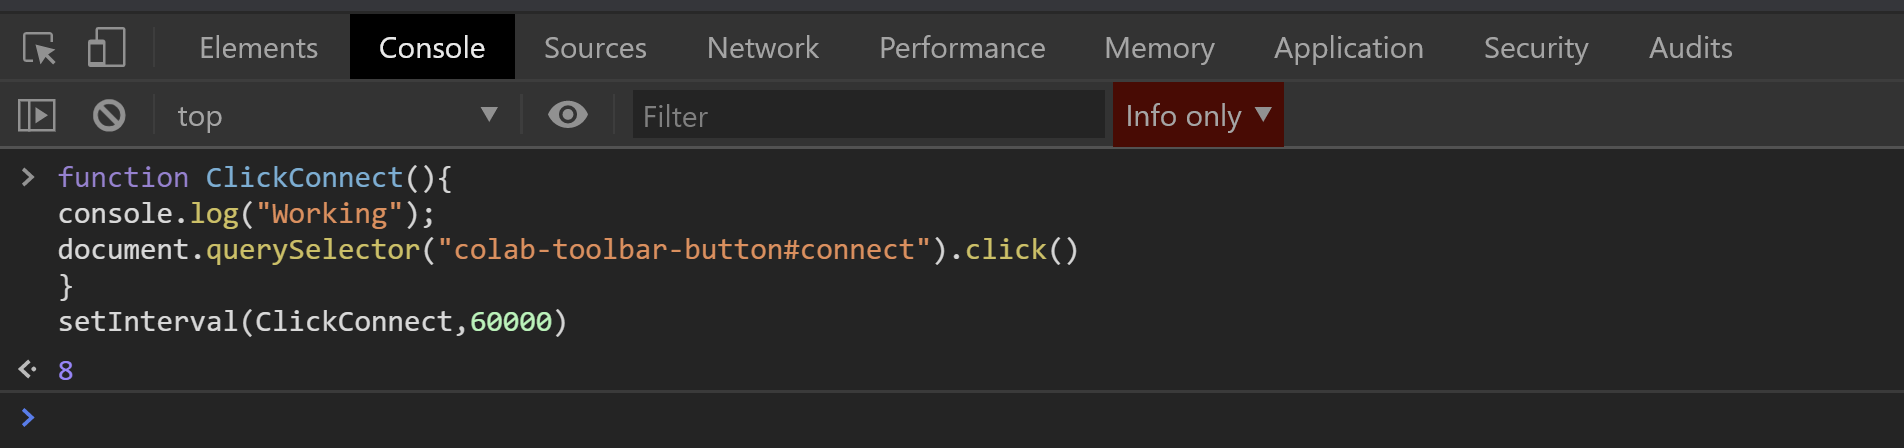

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train your custom detector
#!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.672732), count: 3, class_loss = 0.464623, iou_loss = 0.247010, total_loss = 0.711633 
 total_bbox = 1022302, rewritten_bbox = 0.000489 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.823228), count: 10, class_loss = 0.718690, iou_loss = 0.328899, total_loss = 1.047589 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.795022), count: 56, class_loss = 5.675817, iou_loss = 2.836804, total_loss = 8.512622 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.689945), count: 7, class_loss = 1.158942, iou_loss = 0.687893, total_loss = 1.846835 
 total_bbox = 1022375, rewritten_bbox = 0.000489 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.841868), count: 6, class_loss = 0.417004, iou_loss = 0.190033, total_loss = 0.607036 
v

You can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you would aim for a loss under 2.

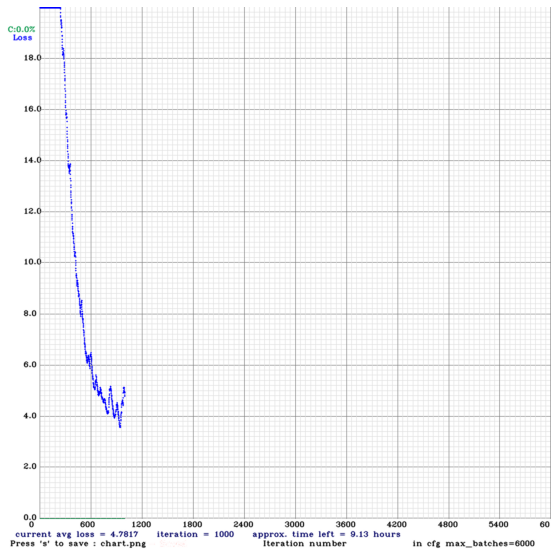

In [ ]:
#imShow('chart.png')

**TRICK**: If for some reason you get an error or your Colab goes idle during training, you have not lost your weights! Every 100 iterations a weights file called **yolov3_custom_last.weights** is saved to **mydrive/yolov3/backup/** folder (wherever your backup folder is). This is why we created this folder in our Google drive and not on the cloud VM. If your runtime crashes and your backup folder was in your cloud VM you would lose your weights and your training progress.

We can kick off training from our last saved weights file so that we don't have to restart! WOOHOO! Just run the following command but with your backup location.
```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [ ]:
#!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show

# Step 6: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections. Time to test it out and have some fun!

In [8]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


/content/darknet/cfg
/content/darknet


## Validation

In [19]:
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_006.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_006.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_008.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_008.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_026.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_026.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_049.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_049.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_059.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_059.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_071.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_071.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_074.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_074.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_087.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_087.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_095.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_095.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_119.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_119.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_139.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_139.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_218.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_218.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_231.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_231.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_249.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_249.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_264.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_264.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_268.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_268.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_272.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_272.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_296.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_296.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_311.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_311.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_351.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_351.txt
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -thresh 0.05 -ext_output /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Images/BloodImage_354.jpg > /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/Validation/Results/BloodImage_354.txt



 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 B

### Calculate MAP
In order to calcu;ate MAP on test data , perform following chages:
Change `obj.data` file to `obj_test.data` as follows:
classes = 3
names = /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/obj.names
Under `.\darknet` directory add `.\darknet\data` theis `obj_test.data` and upload the image paths of test data in a .txt file as `train.txt`
By default the map calculation only consider the `train.txt` naming convention. So the test file is even required to be uploaded as train.txt

In [26]:
!./darknet detector map data/obj_test.data cfg/yolov3_custom.cfg /content/drive/MyDrive/UpGrad/LJMU_MS/Data/YOLO_00/YOLO/weights/yolov3_custom_1000.weights -iou_thresh 0.5

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
valid: Using default 'data/train.txt'
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 

# Thanks!
Thanks for following along this tutorial, I hope it worked well for all of you!

If you enjoy YOLOv3 check out my other videos and subscribe to my channel so you don't miss out on any other amazing YOLOv3 content! 

[The AI Guy](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q)